In [2]:
import sys
sys.path.append('./code')
sys.path.append('../Statistics/code')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
from simulations import IntegrateSchrodingerEquation
from statfunctions import PolynomialFit1D

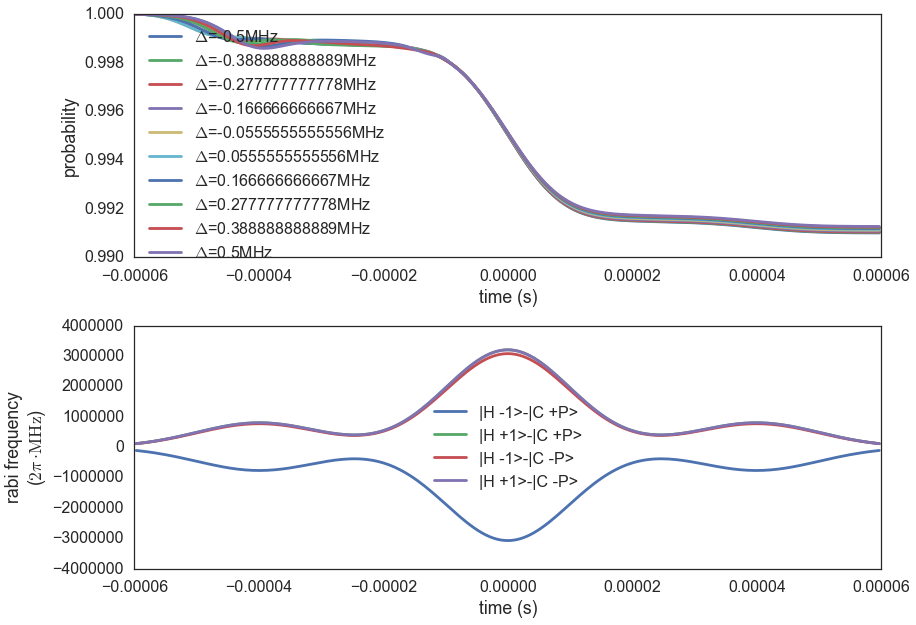

In [11]:
gaussian = lambda t, t0, dt : np.exp(-(t - t0)**2/(2 * dt**2))
gaussian_with_tails = lambda t, t0, dt, Dt=0, a = 0 : (gaussian(t, t0, dt) + 
                                                       a * gaussian(t, t0 + Dt, dt) +
                                                       a * gaussian(t, t0 - Dt, dt))

P = +1
phi = 0
dtheta = .02
theta = -np.pi/4.0 + dtheta
delta = 0
Omega0 = 2 * np.pi * 10**6
Gamma  = 1/(500 * 10**-9)
DeltaC = 2 * np.pi * 50 * 10**6

dt = 10 * 10**-6
T  = 6 * dt
N  = 200

t  = np.linspace(-T, T, N)

state = lambda phi, dtheta=0 : {'|H +1>': np.exp(-1j*phi)*np.cos(dtheta - np.pi/4.0), 
                                '|H -1>': np.exp(+1j*phi)*np.sin(dtheta - np.pi/4.0)}

Omega = Omega0 * gaussian_with_tails(t, 0, dt, 4 * dt, .25)#gaussian(t, 0, dt)

energy = lambda Delta : {'|C -P>': P * DeltaC + Delta - 1j * Gamma/2.0,
                         '|C +P>': +Delta - 1j * Gamma/2.0,
                         '|H +1>': +delta,
                         '|H -1>': -delta}

omega  = lambda Delta : {('|H +1>', '|C +P>'):       Omega * np.exp(-1j*phi) * np.cos(theta)/np.sqrt(2),
                         ('|H -1>', '|C +P>'):   P * Omega * np.exp(+1j*phi) * np.sin(theta)/np.sqrt(2),
                         ('|H +1>', '|C -P>'):       Omega * np.exp(-1j*phi) * np.cos(theta)/np.sqrt(2),
                         ('|H -1>', '|C -P>'): - P * Omega * np.exp(+1j*phi) * np.sin(theta)/np.sqrt(2)}

psi0 = lambda s : state(s * np.pi/2.0)

Delta  = np.linspace(-.5, .5, 10) * 2 * np.pi * 10**6

ISE = IntegrateSchrodingerEquation.parameter_sweep(Delta,
                                                   t=t,
                                                   energy=energy,
                                                   omega =omega,
                                                   psi0 = psi0(1),
                                                   final_state=False,
                                                   parallelize=False)
    
plt.subplot(2,1,1)
for ise, d in zip(ISE, Delta):
    ise.plot(states={('$\Delta$='+str(d/(2 * np.pi* 10**6)) + 'MHz'): {'|H +1>':1, '|H -1>':1}}, plot_norm=False)
plt.subplot(2,1,2)
ISE[0].plot_omega()
plt.tight_layout()

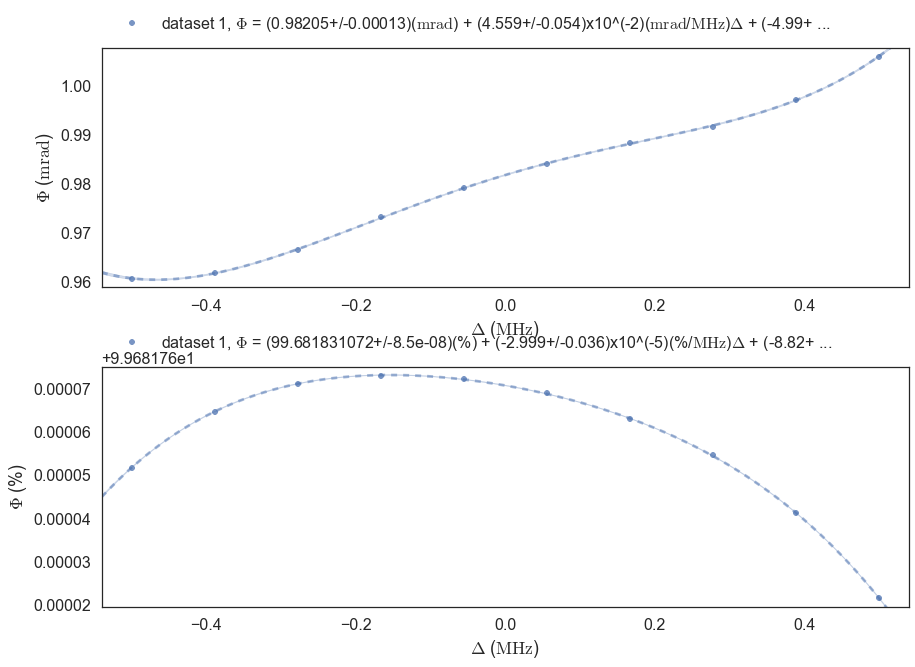

In [18]:
projection_states = lambda phi, dphi, dtheta0=0, dtheta_XY=0: [
                                    state(phi + dphi, dtheta0 + dtheta_XY), 
                                    state(phi - dphi, dtheta0 + dtheta_XY),
                                    state(phi + np.pi/2.0 + dphi, dtheta0 -dtheta_XY), 
                                    state(phi + np.pi/2.0 - dphi, dtheta0 -dtheta_XY)
                    ]

dphi = .05
dtheta0_read = .02
dtheta_XY_read = .0275
Phi = []
C   = []
for ise in ISE:
    sig = []
    A = []
    S = []
    for s in projection_states(np.pi/4.0, dphi, 
                               dtheta0_read, dtheta_XY_read):
        s0 = ise.state_dict_to_array(s)
        sig.append(np.abs(np.dot(np.conj(ise.psi1.T), s0))**2)
    A.append((sig[2] - sig[0])/(sig[2] + sig[0]))
    A.append((sig[3] - sig[1])/(sig[3] + sig[1]))
    c = (A[1] - A[0])/(4 * dphi)
    p = (A[1] + A[0])/(4*c)
    S.append(np.mean(sig))
    Phi.append(p)
    C.append(c)

phi_regr = PolynomialFit1D(np.array(Delta)/(2*np.pi*10**6), np.array(Phi)*10**3, 
                       order = 4, x_name='$\Delta$', x_unit='$\\mathrm{MHz}$',
                       y_name='$\Phi$', y_unit='$\\mathrm{mrad}$')
con_regr = PolynomialFit1D(np.array(Delta)/(2*np.pi*10**6), np.array(C)*100, 
                       order = 4, x_name='$\Delta$', x_unit='$\\mathrm{MHz}$',
                       y_name='$\Phi$', y_unit='%')

plt.subplot(2,1,1)
phi_regr.plot()
plt.subplot(2,1,2)
con_regr.plot()
plt.tight_layout()